#  **Basic Setup installing libraries& getting the data**

In [1]:
!pip install torch torchvision matplotlib tqdm pillow==11.0.0 -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3

In [2]:
!git clone https://github.com/EyadAlN3imi/DS372-Forensics.git

Cloning into 'DS372-Forensics'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (625/625), done.
remote: Compressing objects: 100% (576/576), done.
remote: Total 625 (delta 43), reused 612 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (625/625), 1.89 MiB | 17.95 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Filtering content: 100% (331/331), 16.55 MiB | 2.28 MiB/s, done.


In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torchvision import transforms
import seaborn as sns
from PIL import Image, ImageOps
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = "/content/DS372-Forensics/Datasets/BPA_DATA"
os.listdir(data_path)

['FINAL_ALL_DATA.csv', 'FINAL_ALL_IMAGES']

# **Exploratory data analysis for Blood Pattern analysis**
1.1. Basic Setup – Load Images + CSV

In [5]:
df = pd.read_csv('/content/DS372-Forensics/Datasets/BPA_DATA/FINAL_ALL_DATA.csv')
df

,image_name,class,source_dataset
0,C1_beat.jpg,beating,beating
1,C10_beat.jpg,beating,beating
2,C11_beat.jpg,beating,beating
3,C12_beat.jpg,beating,beating
4,C2_beat.jpg,beating,beating
...,...,...,...
326,9-675.jpg,blood drip,paper75
327,9-775.jpg,blood drip,paper75
328,9-875.jpg,blood drip,paper75
329,9-975.jpg,blood drip,paper75


1.2. Basic Info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_name      331 non-null    object
 1   class           331 non-null    object
 2   source_dataset  331 non-null    object
dtypes: object(3)
memory usage: 7.9+ KB


1.3. Frequency Table + Percent + Cumulative Percent

In [7]:
freq_table = pd.DataFrame({
    'Count': df['class'].value_counts(),
    'Percentage': df['class'].value_counts(normalize=True) * 100
})

freq_table['Cumulative %'] = freq_table['Percentage'][::-1].cumsum()[::-1].round(2)
freq_table['Percentage'] = freq_table['Percentage'].round(2)

freq_table

,Count,Percentage,Cumulative %
class,,,
blood drip,202,61.03,100.00
gun shot,68,20.54,38.97
beating,61,18.43,18.43


1.4. show the class distribution  

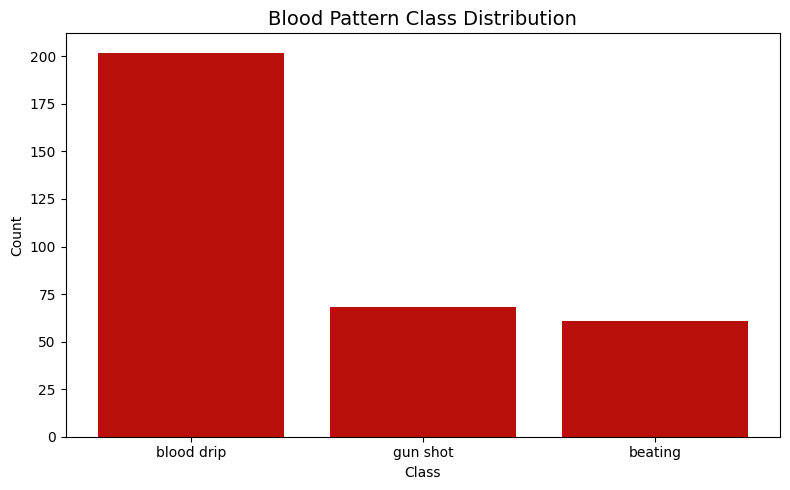

In [8]:
counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))

plt.bar(counts.index, counts.values, color="#B80F0A")

plt.title("Blood Pattern Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()

plt.show()

1.5. Show Random Samples Per Class

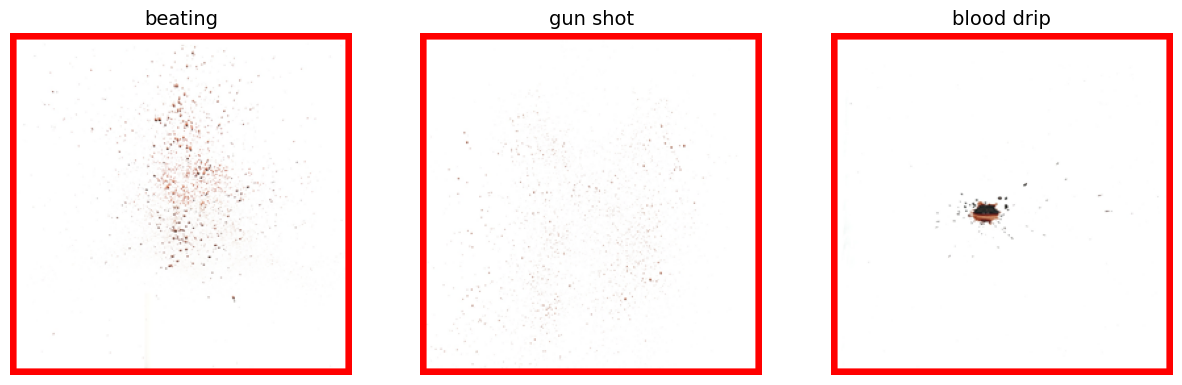

In [11]:
img_dir = os.path.join(data_path, "FINAL_ALL_IMAGES")

classes = df['class'].unique()

fig, ax = plt.subplots(1, len(classes), figsize=(5 * len(classes), 6))

for i, cls in enumerate(classes):
    subset = df[df['class'] == cls]
    img_name = subset.sample(1)['image_name'].values[0]
    path = os.path.join(img_dir, img_name)

    img = Image.open(path).resize((250, 250))

    img = ImageOps.expand(img, border=5, fill="red")

    ax[i].imshow(img)
    ax[i].set_title(cls, fontsize=14)
    ax[i].axis("off")

plt.subplots_adjust(wspace=0.2)
plt.show()


# Embedding Extraction & Dimensionality Reduction

1.6. Loading embeddings model

In [12]:
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def get_dino_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        emb = dino_model(img)
    return emb.cpu().numpy().flatten()

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 244MB/s]


1.7. Extract embeddings

In [13]:
embeddings = []
labels = []

print(f"Processing {len(df)} images...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(img_dir, row['image_name'])
    label = row['class']

    emb = get_dino_embedding(img_path)
    embeddings.append(emb)
    labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"\nEmbeddings extracted")
print(f"  - Shape: {embeddings.shape}")
print(f"  - Embedding dimension: {embeddings.shape[1]}")

Processing 331 images...


100%|██████████| 331/331 [01:22<00:00,  4.04it/s]


✓ Embeddings extracted
  - Shape: (331, 384)
  - Embedding dimension: 384


1.8. Normalize the embeddings

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

print(f"✓ Features normalized")
print(f"  - Shape: {X_scaled.shape}")
print(f"  - Mean: {X_scaled.mean(axis=0)[:5]}...")
print(f"  - Std: {X_scaled.std(axis=0)[:5]}...")

✓ Features normalized
  - Shape: (331, 384)
  - Mean: [ 3.2413403e-09 -3.1513029e-08  8.9677080e-08 -2.3330896e-08
  1.1668825e-07]...
  - Std: [1.         1.0000001  1.0000001  0.99999976 1.0000001 ]...


1.9. t-SNE to 3D

In [15]:
tsne = TSNE(
    n_components=3,
    learning_rate='auto',
    init='pca',
    perplexity=15,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

print(f"t-SNE - Shape: {X_tsne.shape}")

t-SNE - Shape: (331, 3)


1.10. 3D Scatter Plots

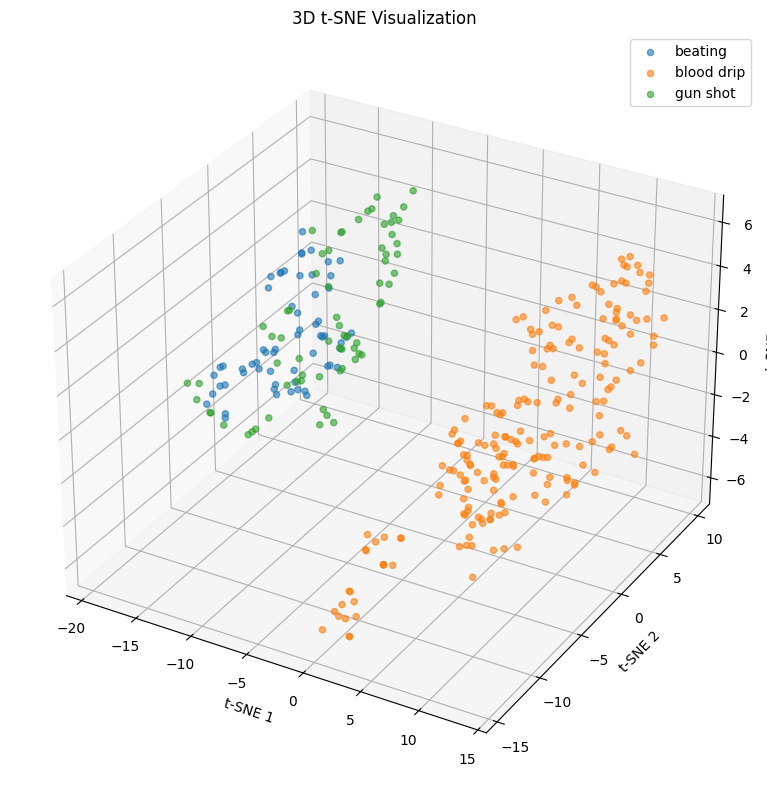

In [30]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2], label=label, s=20, alpha=0.6)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('3D t-SNE Visualization')
ax.legend()

plt.tight_layout()
plt.show()

In [24]:
fig = px.scatter_3d(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    z=X_tsne[:, 2],
    color=labels,
    title="3D t-SNE Visualization",
    labels={
        "x": "t-SNE 1",
        "y": "t-SNE 2",
        "z": "t-SNE 3",
        "color": "Class"
    }
)

fig.update_traces(marker=dict(size=4))
fig.show()